In [3]:
import MGTomo.model as mgmodel
import time
import numpy as np
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch_box

from MGTomo.gridop import P,R, RBox, PBox

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [4]:
max_levels = 1
maxIter = [5,5]

In [5]:
N = 255
# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [6]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [7]:
#c0 = A[0].sumnorm()
#tau0 = 0.5 * 1/c0

In [8]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

In [9]:
#c0 = 56.0952
#tau0 = 0.5 * 1/c0

c0 = 100
tau0 = 0.5 * 1/c0

In [10]:
tau = [tau0]*(max_levels+1)

In [11]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        y_norm = matrix_norm(y, ord = 1)
        return gcond and (y_diff_norm >= eta * y_norm)
    else:
        #print('y_last was none')
        return gcond

In [18]:
def coarse_condition(y, grad_y, kappa, y_last = None):
    gcond = (matrix_norm(R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        return gcond and (y_diff_norm >= kappa)
    else:
        return gcond
    
def MLO_box(fh, y, last_pts: list, l=0, kappa = 0.5, verbose = True):
    x = RBox(y).detach().requires_grad_(True)
    y0, x0 = y, x.clone().detach().requires_grad_(True)
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    #print('coarse correction at l = ', l)
    if coarse_condition(y, grad_fhy0, kappa, last_pts[l]):
        print(l, ' : coarse correction activated')
        print('kl(y^*, y^k): ', fcts.kl_distance_no_matrix(x_torch, y0))

        last_pts[l] = y0.clone().detach()
    
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = RBox(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        
        for i in range(maxIter[l]):
            x.retain_grad()
            val = fcts.BSMART(psi, x, tau[l+1])
            x = val.clone().detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts, _ = MLO_box(psi, x, last_pts, l+1)

        assert psi(x) <= fH(x0) + torch.sum(kappa * x0), 'psi(x) < psi(x0) = fH(x0) does not hold'
    else: 
        print(l, ' : coarse correction not activated')
    
    d = PBox(x-x0)
    z, a = armijo_linesearch_box(fh, y0, d, verbose = verbose)
    print('kl(y^*, z): ', fcts.kl_distance_no_matrix(x_torch, z))
    
    assert z.min() >= 0
    
    for i in range(maxIter[l]):
        z.retain_grad()
        zval = fcts.BSMART(fh, z, tau[l])
        y0.grad.zero_()
        z = zval.clone().detach().requires_grad_(True)
    print('kl(y^*, y^k+1): ', fcts.kl_distance_no_matrix(x_torch, z))
    return z, last_pts, a


In [19]:
a = []
z0 = torch.rand(N, N, requires_grad = True)
w0 = z0.clone().detach().requires_grad_(True)
fhz0 = fh(z0).item()
last_pts = [None]*(max_levels+1)


iteration_times_ML = []
overall_start_time_ML = time.process_time()  # Start overall timing

fval_ML = []

for i in range(100):
    iteration_start_time_ML = time.process_time()  # Start timing for this iteration
    
    val, ylast, alpha = MLO_box(fh, z0, last_pts, verbose=False)
    z0 = val.clone().detach().requires_grad_(True)
    a.append(alpha)
    
    iteration_end_time_ML = time.process_time()  # End timing for this iteration
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML  # Calculate elapsed time for this iteration
    iteration_times_ML.append(iteration_time_ML)

    fval_ML.append(fh(z0).detach().numpy()/fhz0)
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.process_time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
kl(y^*, y^k):  tensor(24367.6316, dtype=torch.float64, grad_fn=<AddBackward0>)
kl(y^*, z):  tensor(24367.4043, dtype=torch.float64, grad_fn=<AddBackward0>)
kl(y^*, y^k+1):  tensor(7615.2241, dtype=torch.float64, grad_fn=<AddBackward0>)
Iteration 0: 72371.96045880832 - Time: 17.528290 seconds
0  : coarse correction activated
kl(y^*, y^k):  tensor(7615.2241, dtype=torch.float64, grad_fn=<AddBackward0>)
kl(y^*, z):  tensor(7614.4389, dtype=torch.float64, grad_fn=<AddBackward0>)
kl(y^*, y^k+1):  tensor(7088.2973, dtype=torch.float64, grad_fn=<AddBackward0>)
Iteration 1: 26321.871867043636 - Time: 16.361670 seconds
0  : coarse correction activated
kl(y^*, y^k):  tensor(7088.2973, dtype=torch.float64, grad_fn=<AddBackward0>)
kl(y^*, z):  tensor(7086.1364, dtype=torch.float64, grad_fn=<AddBackward0>)
kl(y^*, y^k+1):  tensor(6828.4821, dtype=torch.float64, grad_fn=<AddBackward0>)
Iteration 2: 13771.0178879684 - Time: 16.102501 seconds
0  : coarse correction act

In [ ]:
iteration_times_SL = []
overall_start_time_SL = time.process_time()  # Start overall timing

fval_SL = []

for i in range(100):
    iteration_start_time_SL = time.process_time()  # Start timing for this iteration
    
    val = fcts.BSMART(fh, w0, tau0)
    w0 = val.clone().detach().requires_grad_(True)
    
    iteration_end_time_SL = time.process_time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    iteration_times_SL.append(iteration_time_SL)

    fval_SL.append(fh(w0).item()/fhz0)
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.process_time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 197781.7769816271 - Time: 2.533859 seconds
Iteration 1: 151241.46427178726 - Time: 2.749626 seconds
Iteration 2: 117113.26047957505 - Time: 2.620539 seconds
Iteration 3: 91514.27267206815 - Time: 2.523689 seconds
Iteration 4: 72135.24227677788 - Time: 2.526326 seconds
Iteration 5: 57407.506156475516 - Time: 2.502953 seconds
Iteration 6: 46191.803615461 - Time: 2.557221 seconds
Iteration 7: 37635.60864606557 - Time: 2.541200 seconds
Iteration 8: 31093.593602925706 - Time: 2.736204 seconds
Iteration 9: 26075.861054947993 - Time: 2.509276 seconds
Iteration 10: 22210.78691627058 - Time: 2.525721 seconds
Iteration 11: 19217.047021595656 - Time: 2.533615 seconds
Iteration 12: 16882.14382915407 - Time: 2.527864 seconds
Iteration 13: 15045.87896592134 - Time: 2.526554 seconds
Iteration 14: 13587.65479870995 - Time: 2.556908 seconds
Iteration 15: 12416.765092867552 - Time: 2.740084 seconds
Iteration 16: 11465.00993495531 - Time: 2.498681 seconds
Iteration 17: 10681.098104162134 - T

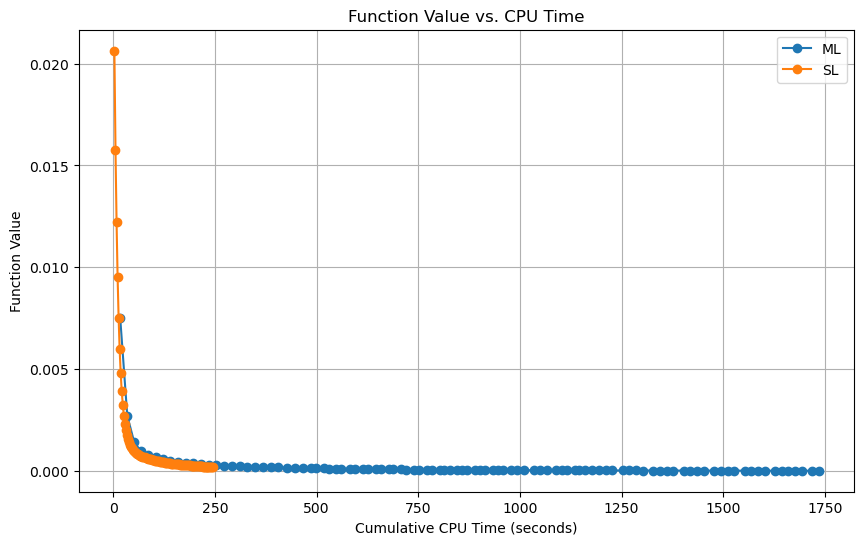

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times_ML, fval_ML, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, fval_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('Function Value')
plt.title('Function Value vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')